# Nexa Distill Dataset Overview

This notebook inspects `data/raw/combined_scientific_papers.parquet` to establish baseline statistics ahead of distillation. Execute cells sequentially after ensuring the virtual environment has `pandas` and `pyarrow` installed.

## Notebook Updates

- Capacity rollup now counts `nexa_sci_train_001.jsonl` directly and removes the empty `.zst` placeholder.
- Added a data mix snapshot to sanity-check categorical coverage and text lengths.
- After refreshing counts, rerun the raw summary → HF import → capacity → data mix cells to confirm totals.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

sns.set_theme(style="whitegrid")

root = Path("/Users/allanmurimiwandia/Nexa_compute")
dataset_path = root / "data/raw/combined_scientific_papers.parquet"

# Load the dataset
df = pd.read_parquet(dataset_path)

print(f"Loaded dataset from {dataset_path}")
print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")

# Display the first few rows of the dataset
display(df.head())

Loaded dataset from /Users/allanmurimiwandia/Nexa_compute/data/raw/combined_scientific_papers.parquet
Rows: 22 | Columns: 3


,domain,chunk_type,text
0,Computer Science,general,1\nNoise2Ghost: Self-supervised deep convoluti...
1,Computer Science,general,Multimodal Representation Learning Techniques ...
2,Computer Science,general,arXiv:2504.10357v1 [eess.SP] 14 Apr 2025\nTh...
3,Computer Science,general,DUE: A Deep Learning Framework and Library for...
4,Computer Science,general,PG-DPIR: An efficient plug-and-play method for...


In [2]:
column_overview = pd.DataFrame({
    "dtype": df.dtypes,
    "non_null": df.count(),
    "unique": df.nunique(dropna=False),
    "memory_bytes": df.memory_usage(deep=True)
})

print("Column overview:")
display(column_overview)

print("\nMissing values per column:")
display(df.isna().sum().to_frame(name="missing"))

print("\nDataset shape and duplicates:")
print(f"Rows: {len(df):,}, Columns: {len(df.columns)}")
print(f"Duplicate rows (full match): {df.duplicated().sum()}" )
print(f"Duplicate texts: {df['text'].duplicated().sum() if 'text' in df.columns else 'n/a'}")

Column overview:


,dtype,non_null,unique,memory_bytes
Index,NaN,NaN,NaN,132
chunk_type,object,22.0,1.0,1408
domain,object,22.0,3.0,1559
text,object,22.0,19.0,3733159



Missing values per column:


,missing
domain,0
chunk_type,0
text,0



Dataset shape and duplicates:
Rows: 22, Columns: 3
Duplicate rows (full match): 0
Duplicate texts: 3


In [3]:
df["text_length_chars"] = df["text"].astype(str).str.len()
df["text_length_words"] = df["text"].astype(str).str.split().map(len)

length_summary = df[["text_length_chars", "text_length_words"]].describe().T
length_summary["median"] = df[["text_length_chars", "text_length_words"]].median()

print("Text length summary (chars & words):")
display(length_summary)

print("Longest examples by character length:")
display(df.nlargest(3, "text_length_chars")["text"].to_frame())


Text length summary (chars & words):


,count,mean,std,min,25%,50%,75%,max,median
text_length_chars,22.0,46088.545455,20941.271035,20017.0,27422.25,38670.0,61776.25,82994.0,38670.0
text_length_words,22.0,7326.500000,3510.107470,2949.0,4423.00,6082.0,10284.50,14338.0,6082.0


Longest examples by character length:


,text
10,1\nUnleashing Expert Opinion from Social Media...
19,Model Order Reduction of Linear Systems via (γ...
3,DUE: A Deep Learning Framework and Library for...


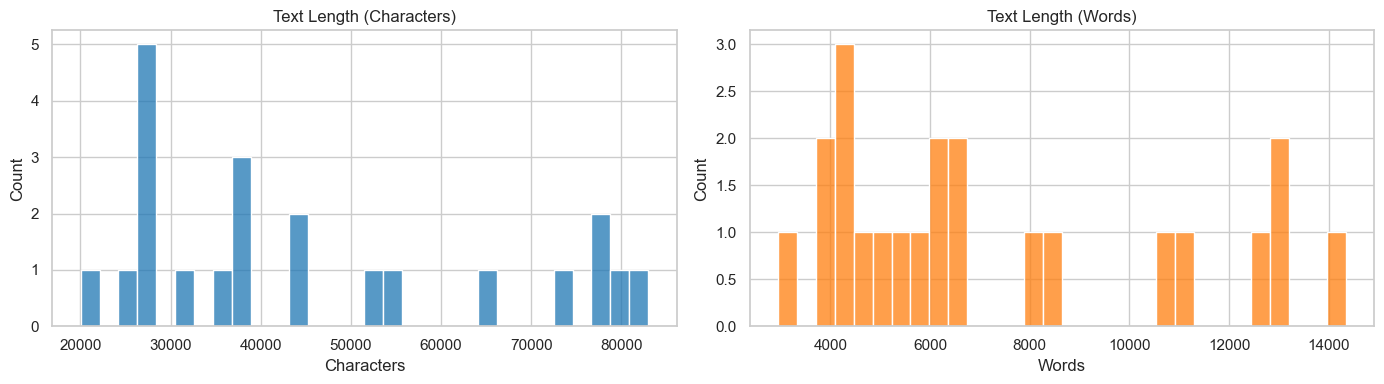

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(data=df, x="text_length_chars", bins=30, ax=axes[0], color="#1f77b4")
axes[0].set_title("Text Length (Characters)")
axes[0].set_xlabel("Characters")

sns.histplot(data=df, x="text_length_words", bins=30, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Text Length (Words)")
axes[1].set_xlabel("Words")

plt.tight_layout()
plt.show()

Domain distribution:


,count
domain,
Computer Science,9
Materials Science,7
Physics,6


/var/folders/j2/vs4kw40x3wq6rjbv72d0jy3h0000gn/T/ipykernel_8638/3309309086.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="domain", order=domain_counts.index, palette="viridis")


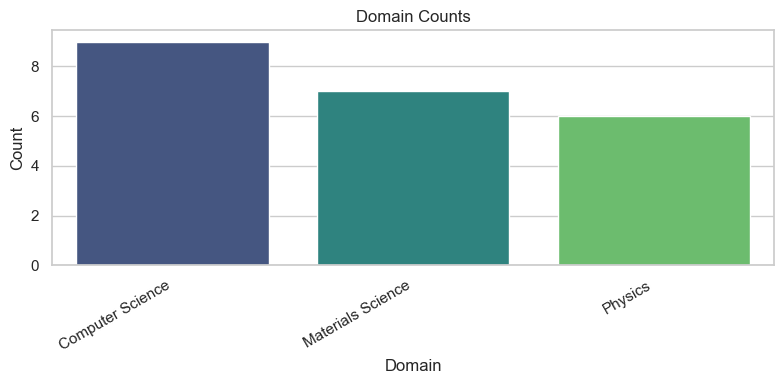


Chunk type distribution:


,count
chunk_type,
general,22


/var/folders/j2/vs4kw40x3wq6rjbv72d0jy3h0000gn/T/ipykernel_8638/3309309086.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="chunk_type", order=chunk_counts.index, palette="mako")


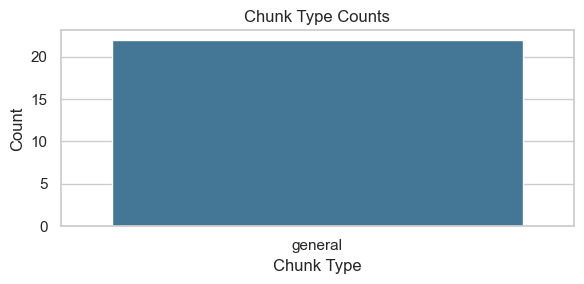

In [5]:
if "domain" in df.columns:
    domain_counts = df["domain"].value_counts(dropna=False).sort_values(ascending=False)
    print("Domain distribution:")
    display(domain_counts.to_frame(name="count"))

    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x="domain", order=domain_counts.index, palette="viridis")
    plt.title("Domain Counts")
    plt.xlabel("Domain")
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'domain' not found in dataset.")

if "chunk_type" in df.columns:
    chunk_counts = df["chunk_type"].value_counts(dropna=False).sort_values(ascending=False)
    print("\nChunk type distribution:")
    display(chunk_counts.to_frame(name="count"))

    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x="chunk_type", order=chunk_counts.index, palette="mako")
    plt.title("Chunk Type Counts")
    plt.xlabel("Chunk Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'chunk_type' not found in dataset.")

In [6]:
# Define labelled fields (defaults to non-text columns)
labelled_fields = ["domain", "chunk_type"]

# Check what fields are not labelled
unlabelled_fields = [field for field in df.columns if field not in labelled_fields]
print("\nUnlabelled fields:")
display(pd.DataFrame(list(unlabelled_fields), columns=["Field"]))

# Check for any missing values in labelled fields
missing_values = df[labelled_fields].isna().sum()
print("\nMissing values in labelled fields:")
display(missing_values.to_frame(name="count"))

# Check for any duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()


Unlabelled fields:


,Field
0,text
1,text_length_chars
2,text_length_words



Missing values in labelled fields:


,count
domain,0
chunk_type,0


In [7]:
# print out some of the text in the dataset such as abstract, title, etc
print(df["text"].head())
# print out the first 10 rows of the dataset
print(df.head(10))
# print out the last 10 rows of the dataset
print(df.tail(10))

0    1\nNoise2Ghost: Self-supervised deep convoluti...
1    Multimodal Representation Learning Techniques ...
2    arXiv:2504.10357v1  [eess.SP]  14 Apr 2025\nTh...
3    DUE: A Deep Learning Framework and Library for...
4    PG-DPIR: An efficient plug-and-play method for...
Name: text, dtype: object
              domain chunk_type  \
0   Computer Science    general   
1   Computer Science    general   
2   Computer Science    general   
3   Computer Science    general   
4   Computer Science    general   
5   Computer Science    general   
6   Computer Science    general   
7   Computer Science    general   
8   Computer Science    general   
9  Materials Science    general   

                                                text  text_length_chars  \
0  1\nNoise2Ghost: Self-supervised deep convoluti...              53379   
1  Multimodal Representation Learning Techniques ...              53671   
2  arXiv:2504.10357v1  [eess.SP]  14 Apr 2025\nTh...              26748   
3  DUE: A Dee

In [8]:
# print out stats about the dataset such as size number of rows and columns and size of the dataset in storage
print(f"Dataset size: {df.size}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Dataset size in storage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
# print out the number of unique values in each column
print(df.nunique())
# print out the number of missing values in each column
print(df.isna().sum())
# print out the number of duplicate rows in the dataset
print(df.duplicated().sum())
# print out the number of duplicate values in the dataset
print(df.duplicated(subset=["text"]).sum())

Dataset size: 110
Number of rows: 22
Number of columns: 5
Dataset size in storage: 3.56 MB
domain                3
chunk_type            1
text                 19
text_length_chars    19
text_length_words    19
dtype: int64
domain               0
chunk_type           0
text                 0
text_length_chars    0
text_length_words    0
dtype: int64
0
3


In [9]:
import io
import json
import math
from collections import defaultdict

import zstandard as zstd

raw_dir = root / "data/raw"
raw_summary = []
raw_samples: dict[str, list[dict | str]] = {}

# Helper to iterate jsonl (optionally compressed) without loading everything into memory

def iter_jsonl(path, max_lines=None, sample_limit=5):
    counter = 0
    samples = []
    if path.suffixes and path.suffixes[-1] == ".zst":
        reader = io.TextIOWrapper(zstd.open(path, "rb"), encoding="utf-8")
    else:
        reader = path.open("r", encoding="utf-8")

    with reader as handle:
        for line in handle:
            counter += 1
            if sample_limit is not None and len(samples) < sample_limit:
                try:
                    samples.append(json.loads(line))
                except json.JSONDecodeError:
                    samples.append(line.strip())
            if max_lines is not None and counter >= max_lines:
                break
    return counter, samples

for path in sorted(raw_dir.iterdir()):
    if not path.is_file():
        continue

    entry = {
        "file": path.name,
        "size_mb": round(path.stat().st_size / 1_048_576, 2),
        "suffix": "".join(path.suffixes),
        "records": None,
        "notes": None,
    }

    try:
        if path.suffix == ".json":
            data = json.loads(path.read_text())
            if isinstance(data, list):
                entry["records"] = len(data)
                raw_samples[path.name] = data[:5]
            elif isinstance(data, dict):
                list_keys = {k: v for k, v in data.items() if isinstance(v, list)}
                entry["records"] = sum(len(v) for v in list_keys.values())
                entry["notes"] = f"keys={list(list_keys.keys())[:3]}"
                combined_sample = []
                for values in list_keys.values():
                    combined_sample.extend(values[:2])
                raw_samples[path.name] = combined_sample[:5]
        elif path.suffix in {".jsonl", ".ndjson"} or (path.suffixes and path.suffixes[-1] == ".zst"):
            count, samples = iter_jsonl(path, max_lines=500_000, sample_limit=5)
            entry["records"] = count
            raw_samples[path.name] = samples
        else:
            entry["notes"] = "format not parsed"
    except Exception as exc:  # pragma: no cover - defensive for ad‑hoc files
        entry["notes"] = f"error: {exc}"

    raw_summary.append(entry)

raw_summary_df = pd.DataFrame(raw_summary).sort_values("size_mb", ascending=False)
print("Raw data files:")
display(raw_summary_df)

print("\nSample content (truncated per file):")
for fname, samples in raw_samples.items():
    print(f"\n↳ {fname}")
    for idx, sample in enumerate(samples, start=1):
        preview = sample
        if isinstance(sample, (dict, list)):
            preview = json.dumps(sample, ensure_ascii=False)[:400]
        else:
            preview = str(sample)[:400]
        print(f"  {idx:>2}: {preview}")


Raw data files:


,file,size_mb,suffix,records,notes
8,scientific_corpus_325M.jsonl,3242.86,.jsonl,167963.0,None
5,nexa_sci_train_001.jsonl,618.82,.jsonl,33218.0,None
6,nexa_sci_train_001.jsonl.zst,83.63,.jsonl.zst,NaN,error: zstd decompress error: Unknown frame de...
4,nexa_sci_train_000.jsonl.zst,10.95,.jsonl.zst,16609.0,None
2,combined_scientific_papers.parquet,0.46,.parquet,NaN,format not parsed
1,biology_enhanced.json,0.08,.json,1000.0,keys=['texts']
3,materials_enhanced.json,0.06,.json,1000.0,keys=['texts']
7,physics_enhanced.json,0.06,.json,1000.0,keys=['texts']
0,.gitkeep,0.00,,NaN,format not parsed



Sample content (truncated per file):

↳ biology_enhanced.json
   1: Provide a comprehensive explanation of CRISPR gene editing including its molecular mechanisms
   2: Analyze the evolutionary significance of protein folding in biological systems

↳ materials_enhanced.json
   1: Analyze the structure-property relationships in nanocomposites
   2: Describe the processing methods for smart materials

↳ nexa_sci_train_000.jsonl.zst
   1: {"title": "Editorial overview--New frontiers of biophysical methods: tools for structural biology and beyond.", "abstract": "", "full_text": "", "domain": "biology", "section": "abstract", "source": "pubmed", "authors": [], "published": null, "provenance": {"pubmed_id": "25292464"}, "categories": ["biology"], "text": "", "domain_tag": "[BIO]", "section_tag": "[ABSTRACT]", "task_tag": "", "routing_
   2: {"title": "Editorial: The application of systems biology and bioinformatics methods in proteomics, transcriptomics and metabolomics (PART II).", "abstrac

In [10]:
# Attempt to inspect the larger shard that previously failed to decompress
nexa_001_path = raw_dir / "nexa_sci_train_001.jsonl.zst"

try:
    count_001, samples_001 = iter_jsonl(nexa_001_path, max_lines=None, sample_limit=3)
    print(
        f"Decompressed '{nexa_001_path.name}' successfully — estimated rows: {count_001:,}"
    )
    for idx, sample in enumerate(samples_001, start=1):
        preview = json.dumps(sample, ensure_ascii=False)[:400]
        print(f"  {idx:>2}: {preview}")
except Exception as exc:  # pragma: no cover - defensive path
    print(f"Failed to read {nexa_001_path.name}: {exc}")
    count_001 = 0


Failed to read nexa_sci_train_001.jsonl.zst: zstd decompress error: Unknown frame descriptor


In [11]:
from datasets import load_dataset

hf_ds_id = "Allanatrix/Scientific_Research_Tokenized"
ds = load_dataset(hf_ds_id, split="train")  # requires huggingface-cli login first
print(f"{hf_ds_id} rows: {len(ds):,}")

/Users/allanmurimiwandia/Nexa_compute/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Allanatrix/Scientific_Research_Tokenized rows: 33,218


In [12]:
# Estimate how many teacher-ready samples we could potentially curate
estimates = raw_summary_df[['file', 'records']].copy()
if 'records' not in estimates:
    estimates['records'] = 0
estimates['records'] = estimates['records'].fillna(0).astype(int)
hf_file = 'nexa_sci_train_001.jsonl'
if 'count_001' in globals():
    hf_records = int(count_001)
    mask_existing = estimates['file'].eq(hf_file)
    if mask_existing.any():
        estimates.loc[mask_existing, 'records'] = hf_records
    else:
        estimates = pd.concat([
            estimates,
            pd.DataFrame([{'file': hf_file, 'records': hf_records}])
        ], ignore_index=True)
    zipped_mask = estimates["file"].eq(hf_file + ".zst")
    if zipped_mask.any():
        estimates = estimates.loc[~zipped_mask]
estimates = (
    estimates
    .sort_values('records', ascending=False)
    .reset_index(drop=True)
)
total_records = int(estimates['records'].sum())
display(estimates)
print(f"Total raw rows available (best-effort): {total_records:,}")


,file,records
0,scientific_corpus_325M.jsonl,167963
1,nexa_sci_train_000.jsonl.zst,16609
2,biology_enhanced.json,1000
3,materials_enhanced.json,1000
4,physics_enhanced.json,1000
5,nexa_sci_train_001.jsonl,0
6,combined_scientific_papers.parquet,0
7,.gitkeep,0


Total raw rows available (best-effort): 187,572


In [13]:
# Data mix snapshot for the Hugging Face dataset
if 'ds' not in globals():
    raise RuntimeError('Run the Hugging Face import cell first to populate `ds`.')

hf_df = ds.to_pandas()
row_count = len(hf_df)
print(f"Dataset rows: {row_count:,}")

categorical_targets = [col for col in ['domain', 'chunk_type', 'task_type', 'source', 'split'] if col in hf_df.columns]
for col in categorical_targets:
    breakdown = (
        hf_df[col]
        .fillna('<missing>')
        .value_counts(dropna=False)
        .rename_axis(col)
        .reset_index(name='count')
    )
    breakdown['share_pct'] = (breakdown['count'] / row_count * 100).round(2)
    print(f"\n=== {col} breakdown ===")
    display(breakdown)

text_candidates = [col for col in ['text', 'content', 'chunk', 'input_text', 'document'] if col in hf_df.columns]
if text_candidates:
    base_col = text_candidates[0]
    lengths = hf_df[base_col].dropna().map(len)
    length_summary = {
        'field': base_col,
        'avg_chars': round(lengths.mean(), 2),
        'median_chars': lengths.median(),
        'p90_chars': lengths.quantile(0.90),
        'p95_chars': lengths.quantile(0.95),
    }
    display(pd.DataFrame([length_summary]))
else:
    print("\nNo obvious text field detected for length stats; inspect `hf_df.columns` manually.")

if 'enhanced_df' in globals() and not enhanced_df.empty:
    sources = sorted(enhanced_df['source'].unique())
    print(f"\nEnhanced prompt exemplars available: {len(enhanced_df):,} rows across {sources}")
else:
    print("\nEnhanced prompt exemplars not loaded; run the enhanced import cell if needed.")


Dataset rows: 33,218

=== domain breakdown ===


,domain,count,share_pct
0,education,30616,92.17
1,biology,2601,7.83
2,arxiv,1,0.00



=== source breakdown ===


,source,count,share_pct
0,fineweb_edu,30616,92.17
1,pubmed,2601,7.83
2,arxiv,1,0.00


,field,avg_chars,median_chars,p90_chars,p95_chars
0,text,14344.2,2805.0,10929.3,24283.3



Enhanced prompt exemplars not loaded; run the enhanced import cell if needed.


Enhanced prompt files: 3 | Total prompts: 3,000


,prompts,avg_chars
source,,
biology,1000,71.069
materials,1000,52.292
physics,1000,56.406


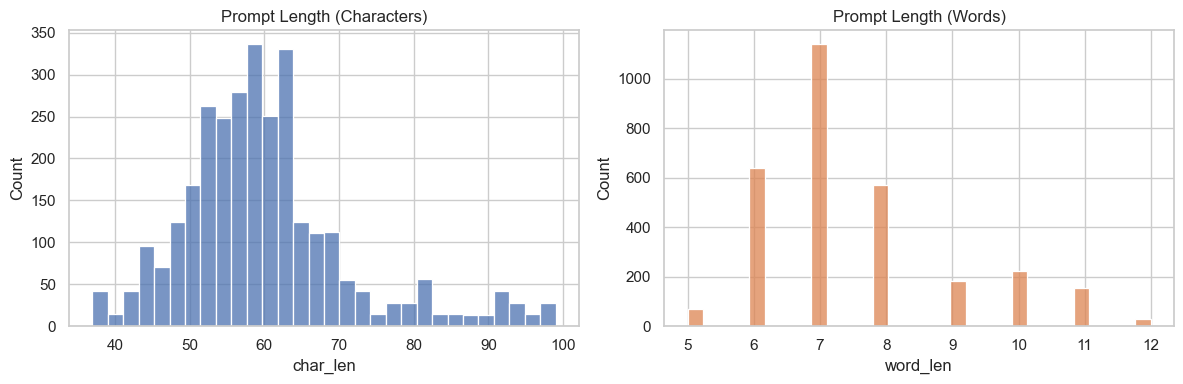

In [14]:
# Aggregate the enhanced prompt sets for quick sanity checks

enhanced_paths = sorted(raw_dir.glob("*_enhanced.json"))
enhanced_rows = []
for path in enhanced_paths:
    data = json.loads(path.read_text())
    if isinstance(data, dict) and "texts" in data:
        for text in data["texts"]:
            enhanced_rows.append(
                {
                    "source": path.stem.replace("_enhanced", ""),
                    "text": text,
                    "char_len": len(text),
                    "word_len": len(text.split()),
                }
            )

enhanced_df = pd.DataFrame(enhanced_rows)
print(f"Enhanced prompt files: {len(enhanced_paths)} | Total prompts: {len(enhanced_df):,}")
display(enhanced_df.groupby("source").agg({"text": "count", "char_len": "mean"}).rename(columns={"text": "prompts", "char_len": "avg_chars"}))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=enhanced_df, x="char_len", bins=30, ax=axes[0], color="#4c72b0")
axes[0].set_title("Prompt Length (Characters)")

sns.histplot(data=enhanced_df, x="word_len", bins=30, ax=axes[1], color="#dd8452")
axes[1].set_title("Prompt Length (Words)")
plt.tight_layout()
plt.show()


In [ ]:
# Pull shard `001` directly from Hugging Face and persist it locally
hf_ds_id = "Allanatrix/Scientific_Research_Tokenized"
hf_split = "train"
print(f"Loading {hf_ds_id}/{hf_split} from the hub...")

ds = load_dataset(hf_ds_id, split=hf_split)
count_001 = len(ds)
print(f"Fetched {count_001:,} rows")

# Save to organized processed data structure
pretrain_root = root / "data" / "processed" / "training" / "pretrain"
pretrain_root.mkdir(parents=True, exist_ok=True)

output_path = pretrain_root / "001.jsonl"
ds.to_json(str(output_path), lines=True, force_ascii=False)
print(f"Wrote {count_001:,} rows to {output_path.relative_to(root)}")

local_listing = sorted(p.name for p in pretrain_root.iterdir())
print(
    f"Available shards ({len(local_listing)} entries): {local_listing[:10]}"
    f"{' ...' if len(local_listing) > 10 else ''}"
)

Loading Allanatrix/Scientific_Research_Tokenized/train from the hub...
Fetched 33,218 rows


Creating json from Arrow format: 100%|██████████| 34/34 [00:06<00:00,  5.24ba/s]

Wrote 33,218 rows to nexa_sci_dataset/data/pretrain/001.jsonl
Available shards (1 entries): ['001.jsonl']


In [ ]:
# Curate enhanced exemplars into Nexa_distill teacher parquet
import json

enhanced_paths = sorted((root / "data/raw").glob("*_enhanced.json"))
if not enhanced_paths:
    raise RuntimeError("No enhanced prompt files found under data/raw.")

template_dir = root / "Nexa_distill" / "prompts"
template_paths = sorted(template_dir.glob("*.txt"))
if not template_paths:
    raise RuntimeError(f"No prompt templates discovered in {template_dir}")

exemplar_rows = []
for path in enhanced_paths:
    payload = json.loads(path.read_text())
    domain = path.stem.replace("_enhanced", "")
    generated_at = payload.get("generated_at")
    for idx, text in enumerate(payload.get("texts", []), start=1):
        exemplar_rows.append({
            "domain": domain,
            "prompt_index": idx,
            "user_prompt": text.strip(),
            "source_file": path.name,
            "generated_at": generated_at,
        })

exemplars_df = pd.DataFrame(exemplar_rows)
print(f"Loaded exemplar instructions: {len(exemplars_df):,}")

prompt_templates = {path.stem: path.read_text().strip() for path in template_paths}

SYSTEM_PROMPT_TEMPLATE = (
    "You are GPT-5 acting as the Nexa scientific teacher. "
    "Given an exemplar instruction and dataset context, craft a distillation-ready "
    "response that satisfies the requirements for the task template \"{template_name}\". "
    "Write in a precise research tone, cite concrete mechanisms when possible, and "
    "do not invent unsupported facts."
)

teacher_rows = []
for template_name, template_body in prompt_templates.items():
    system_prompt = SYSTEM_PROMPT_TEMPLATE.format(template_name=template_name.replace("_", " "))
    for exemplar in exemplars_df.itertuples():
        teacher_rows.append({
            "domain": exemplar.domain,
            "template_name": template_name,
            "user_prompt": exemplar.user_prompt,
            "template_prompt": template_body,
            "system_prompt": system_prompt,
            "source_file": exemplar.source_file,
            "generated_at": exemplar.generated_at,
        })

teacher_df = pd.DataFrame(teacher_rows)
print(f"Teacher request rows: {len(teacher_df):,}")
display(teacher_df.head())

# Save to organized processed data structure
teacher_output_dir = root / "data" / "processed" / "distillation" / "teacher_inputs"
teacher_output_dir.mkdir(parents=True, exist_ok=True)
teacher_parquet_path = teacher_output_dir / "teacher_inputs_v1.parquet"
teacher_df.to_parquet(teacher_parquet_path, index=False)
print(f"Saved teacher parquet -> {teacher_parquet_path}")


Loaded exemplar instructions: 3,000
Teacher request rows: 6,000


,domain,template_name,user_prompt,template_prompt,system_prompt,source_file,generated_at
0,biology,hypothesis,Provide a comprehensive explanation of CRISPR ...,You are an expert scientific assistant. Given ...,You are GPT-5 acting as the Nexa scientific te...,biology_enhanced.json,1.753482e+09
1,biology,hypothesis,Analyze the evolutionary significance of prote...,You are an expert scientific assistant. Given ...,You are GPT-5 acting as the Nexa scientific te...,biology_enhanced.json,1.753482e+09
2,biology,hypothesis,Describe the clinical implications of stem cel...,You are an expert scientific assistant. Given ...,You are GPT-5 acting as the Nexa scientific te...,biology_enhanced.json,1.753482e+09
3,biology,hypothesis,Explain how metabolic pathways contributes to ...,You are an expert scientific assistant. Given ...,You are GPT-5 acting as the Nexa scientific te...,biology_enhanced.json,1.753482e+09
4,biology,hypothesis,Detail the regulatory pathways involved in sig...,You are an expert scientific assistant. Given ...,You are GPT-5 acting as the Nexa scientific te...,biology_enhanced.json,1.753482e+09


Saved teacher parquet -> /Users/allanmurimiwandia/Nexa_compute/Nexa_distill/teacher_inputs.parquet


In [ ]:
# Persist system prompt template and manifest to disk
artifact_dir = root / "Nexa_distill" / "artifacts"
artifact_dir.mkdir(parents=True, exist_ok=True)

system_prompt_path = root / "data" / "system_prompt_template.txt"
system_prompt_path.parent.mkdir(parents=True, exist_ok=True)
system_prompt_path.write_text(SYSTEM_PROMPT_TEMPLATE.strip())
print(f"Saved system prompt template -> {system_prompt_path}")

# Save manifest to organized location
manifest_dir = root / "data" / "processed" / "distillation" / "manifests"
manifest_dir.mkdir(parents=True, exist_ok=True)

manifest = {
    "teacher_parquet": str(teacher_parquet_path.relative_to(root)),
    "system_prompt_template": str(system_prompt_path.relative_to(root)),
    "prompt_templates": sorted(path.name for path in template_paths),
    "enhanced_sources": sorted(path.name for path in enhanced_paths),
    "rows": len(teacher_df),
    "version": "v1",
    "generated_at": pd.Timestamp.now().isoformat(),
}

manifest_path = manifest_dir / "distillation_manifest_v1.json"
manifest_path.write_text(json.dumps(manifest, indent=2))
print(f"Saved manifest -> {manifest_path}")
display(manifest)

Saved system prompt template -> /Users/allanmurimiwandia/Nexa_compute/data/system_prompt_template.txt
Saved manifest -> /Users/allanmurimiwandia/Nexa_compute/Nexa_distill/artifacts/distillation_manifest.json


{'teacher_parquet': 'Nexa_distill/teacher_inputs.parquet',
 'system_prompt_template': 'data/system_prompt_template.txt',
 'prompt_templates': ['hypothesis.txt', 'methodology.txt'],
 'enhanced_sources': ['biology_enhanced.json',
  'materials_enhanced.json',
  'physics_enhanced.json'],
 'rows': 6000}